In [1]:
# get datasetd from "geometry of truth paper"
!git clone https://github.com/saprmarks/geometry-of-truth.git /root/geometry-of-truth
!mv /root/geometry-of-truth/datasets/*.csv data

Cloning into '/root/geometry-of-truth'...


remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 273 (delta 55), reused 59 (delta 45), pack-reused 195
Receiving objects: 100% (273/273), 71.49 MiB | 40.03 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [2]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [3]:
# import my modules
import importlib
# join the path to the modules to the current working directory
import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision = torch.float16
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
os.makedirs(plots_folder, exist_ok=True)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    # get access token from environment variable
    access_token = os.getenv("HF_TOKEN")
    if not access_token:
        access_token = input("Please set the HF_TOKEN environment variable to your Hugging Face access token.")
    # access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=precision, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id


batch_size = 64
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [5]:
# iterate through all csv files in data folder
for file in os.listdir('data'):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv('data/'+file)
    print('\n','#'*10, file, '#'*10)
    # print column names
    print(df.columns)


 ########## instructions.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## cities.csv ##########
Index(['statement', 'label', 'city', 'country', 'correct_country'], dtype='object')

 ########## cities_cities_conj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## cities_cities_disj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## common_claim.csv ##########
Index(['Unnamed: 0', 'examples', 'label', 'agreement'], dtype='object')

 ########## common_claim_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## companies_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 

In [7]:
def train_on_csv(model, tokenizer, module_names, dataset_name='common_claim', probe_type='LR', train_perc=0.8):
    train_dataset = load_csv_dataset(dataset_name = dataset_name)

    # returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
    train_dataset['hidden_states'] = get_hidden(model, tokenizer, module_names, train_dataset['org_data'], batch_size=batch_size, token_position=-1)

    train_data, test_data, train_labels, test_labels = prep_data(train_dataset['hidden_states'], train_dataset['label'], train_perc=train_perc)

    # training probes
    probes = {}
    for idx, module in tqdm(enumerate(module_names), total=num_modules):
        if probe_type == 'MassMean':
            probes[module] = MassMeanProbe()
            probes[module].train(train_data[idx], train_labels)
        elif probe_type == 'LR':
            probes[module] = LRProbe(d_in=model.config.hidden_size, device='cuda', dtype=torch.float32)
            probes[module].train(train_data[idx], train_labels, epochs=2, batch_size=batch_size)

    # test on same dataset
    test_accs = {}
    train_accs = {}
    for idx, module in enumerate(module_names):
        test_accs[module] = probes[module].test(test_data[idx], test_labels)
        train_accs[module] = probes[module].test(train_data[idx], train_labels)


    # print every 5th test acc:
    for index, (key, value) in enumerate(test_accs.items()):
        if index % 5 == 0:
            print(f'{key}\t{value:.2g}') 

    return probes

def test_on_csv(model, tokenizer, dataset_name, probes):
    test_dataset = load_csv_dataset(dataset_name = dataset_name)






In [8]:
probe_type = 'LR'
probes = train_on_csv(model, tokenizer, module_names, dataset_name='common_claim', probe_type=probe_type, train_perc=0.8)

100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


model.layers.0	0.59
model.layers.5	0.66
model.layers.10	0.77
model.layers.15	0.81
model.layers.20	0.8
model.layers.25	0.79
model.layers.30	0.78


In [16]:
test_dataset.keys()


dict_keys(['dataset_name', 'org_data', 'label'])

In [24]:
test_dataset = load_csv_dataset('cities')

lies = np.array(test_dataset['org_data'])[np.array(test_dataset['label']) == 0]
truths = np.array( test_dataset['org_data'])[np.array(test_dataset['label']) == 1]

test_dataset['output_tokens_lie'], _ = generate_tokens(model, tokenizer, list(lies), max_new_tokens=1, batch_size=64, do_sample=False)
test_dataset['output_tokens_truth'], _ = generate_tokens(model, tokenizer, list(truths), max_new_tokens=1, batch_size=64, do_sample=False)


12it [00:03,  3.39it/s]                        
12it [00:03,  3.74it/s]                        


In [190]:
# test on out of distribution dataset

test_dataset_name = 'Statements1000' #  Statements1000, FreebaseStatements, Burglar
max_new_tokens = 20 if test_dataset_name == 'Burglar' else 10

# load dataset
test_dataset = load_data_set(test_dataset_name)
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"
    change_format(test_dataset, lie_format, truth_format)

print('\nGenerating truths and lies')
get_overlap_truth_lies(model, tokenizer, test_dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)
# get hidden states for the new dataset



Generating truths and lies
Size of dataset Statements1000: 1012


  7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

16it [00:15,  1.01it/s]                        
16it [00:00, 1012.67it/s]             


Success rate when generating truths: 74.90%


16it [00:16,  1.02s/it]                        
16it [00:00, 1020.00it/s]             

Success rate when generating lies:   62.35%
Overlap: 42.29%


# evolution of acc over all tokens

In [40]:
attention_mask_lie = test_dataset['output_tokens_lie']['attention_mask']
attention_mask_truth = test_dataset['output_tokens_truth']['attention_mask']

max_num_tokens_lie = attention_mask_lie.shape[1]
max_num_tokens_truth = attention_mask_truth.shape[1]
num_samples = attention_mask_lie.shape[0]
hidden_dim = model.config.hidden_size
max_num_tokens_lie, max_num_tokens_truth
max_tokens = max(max_num_tokens_lie, max_num_tokens_truth)


In [39]:
tokenizer.pad_token_id

2

In [41]:
# make equal size:
if max_num_tokens_lie>max_num_tokens_truth:
    attention_mask_truth = torch.cat([torch.zeros(num_samples, max_num_tokens_lie-max_num_tokens_truth).to(device=attention_mask_truth.device, dtype=attention_mask_truth.dtype), attention_mask_truth], dim=1)
    input_ids_truth = torch.cat([torch.ones(num_samples, max_num_tokens_lie-max_num_tokens_truth).to(device=attention_mask_truth.device, dtype=attention_mask_truth.dtype)*tokenizer.pad_token_id, test_dataset['output_tokens_truth']['input_ids']], dim=1)
    test_dataset['output_tokens_truth']['attention_mask'] = attention_mask_lie
    test_dataset['output_tokens_truth']['input_ids'] = input_ids_truth
elif max_num_tokens_lie<max_num_tokens_truth:
    attention_mask_lie = torch.cat([torch.zeros(num_samples, max_num_tokens_truth-max_num_tokens_lie).to(device=attention_mask_lie.device, dtype=attention_mask_lie.dtype), attention_mask_lie], dim=1)
    input_ids_lie = torch.cat([torch.ones(num_samples, max_num_tokens_truth-max_num_tokens_lie).to(device=attention_mask_lie.device, dtype=attention_mask_lie.dtype)*tokenizer.pad_token_id, test_dataset['output_tokens_lie']['input_ids']], dim=1)
    test_dataset['output_tokens_lie']['attention_mask'] = attention_mask_lie
    test_dataset['output_tokens_lie']['input_ids'] = input_ids_lie

In [50]:
switch_to_right_padding = True

def switch_padding_side(attention_mask, input_ids):
    first_non_zeros = torch.argmax(attention_mask, dim=1)
    right_padded_attention = torch.zeros_like(attention_mask_lie).to(device=attention_mask.device, dtype=attention_mask.dtype)
    right_padded_input = torch.ones_like(input_ids).to(device=input_ids.device, dtype=input_ids.dtype)*tokenizer.pad_token_id
    for idx, first_non_zero in enumerate(first_non_zeros):
        right_padded_attention[idx, :max_tokens-first_non_zero] = attention_mask[idx, first_non_zero:]
        right_padded_input[idx, :max_tokens-first_non_zero] = input_ids[idx, first_non_zero:]

    return right_padded_attention, right_padded_input

if switch_to_right_padding:
    test_dataset['output_tokens_truth']['attention_mask'], test_dataset['output_tokens_truth']['input_ids'] = switch_padding_side(test_dataset['output_tokens_truth']['attention_mask'], test_dataset['output_tokens_truth']['input_ids'])
    test_dataset['output_tokens_lie']['attention_mask'], test_dataset['output_tokens_lie']['input_ids'] = switch_padding_side(test_dataset['output_tokens_lie']['attention_mask'], test_dataset['output_tokens_lie']['input_ids'])


In [53]:

# the hidden states are quite large, so we need to split them into smaller batches
half_batch_size = 16

In [55]:
print('\nCalculating hidden states')
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
normalize = True
# i iterate from the back as i use left padding and tokens of lying and truth telling are aligned at the end
probe_output = torch.zeros([num_modules, num_samples*2, max_tokens], device='cpu', dtype=torch.float32)*torch.Tensor([float('nan')])
test_accs = torch.zeros([num_modules, num_samples*2, max_tokens], device='cpu', dtype=torch.float32)*torch.Tensor([float('nan')])
token_positions = range(max_tokens)
for i, j in zip(range(0, num_samples, half_batch_size), range(0, 2*num_samples, 2*half_batch_size)):


    this_batch_size = min(half_batch_size, num_samples-i)

    # indices for combined batch
    start_full = j
    end_full = j+this_batch_size*2

    hidden_states = torch.zeros([num_modules, this_batch_size*2, max_tokens, hidden_dim], device='cpu', dtype=precision)
    attention_mask = torch.zeros([this_batch_size*2, max_tokens], device='cpu', dtype=attention_mask_lie.dtype)

    
    data = {'input_ids': test_dataset['output_tokens_lie']['input_ids'][i:i+this_batch_size],
            'attention_mask': test_dataset['output_tokens_lie']['attention_mask'][i:i+this_batch_size]}
    temp_hidden = get_hidden_from_tokens(model, module_names, data, batch_size=batch_size, token_position=token_positions)
    attention_mask[:this_batch_size, :] = data['attention_mask']

    # set values where attention is zero to nan
    hidden_states[:, :this_batch_size, :, :] = temp_hidden

    data = {'input_ids': test_dataset['output_tokens_truth']['input_ids'][i:i+this_batch_size],
            'attention_mask': test_dataset['output_tokens_truth']['attention_mask'][i:i+this_batch_size]}
    temp_hidden = get_hidden_from_tokens(model, module_names, data, batch_size=batch_size, token_position=token_positions)
    temp_attention = (attention_mask_truth[i:i+this_batch_size, :][None, :, :, None]==1)
    hidden_states[:, this_batch_size:, :, :] = temp_hidden
    attention_mask[this_batch_size:, :] = data['attention_mask']
    test_labels = torch.cat([torch.zeros(this_batch_size), torch.ones(this_batch_size)])
    
    # just average over padding tokens
    # attention_mask = torch.ones([this_batch_size*2, max_tokens], device='cpu', dtype=attention_mask_lie.dtype)


    if normalize:
        # TODO!!!
        # I should still somehow normalize
        # there are a lot of repeated tokens in the beginning 
        # (like all the instructions are exactly the same, if i take the mean over all the tokens, it is going to be heavily biased)
        # calc statistics over samples and token positions
        # calc mean over hidden states only for values where attention is not zero
        temp_hidden = torch.where(condition=attention_mask[None, :, :, None]==1, input=hidden_states, other=torch.Tensor([float('nan')]))
        # mean_test = temp_hidden.nanmean([1, 2], keepdim=True)
        # std_test = temp_hidden.nanmean([1, 2], keepdim=True)
        # hidden_states = (hidden_states - mean_test)/std_test

    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        probe = probes[module]
        for token_pos in range(hidden_states.shape[2]):
            with torch.no_grad():
                acts_batch = hidden_states[idx, :, token_pos].to(device=probe.device, dtype=probe.dtype)
                probe_output[idx, start_full:end_full, token_pos] = probe.forward(acts_batch).detach().cpu()

    test_accs[:, start_full:end_full, :] = (probe_output[:, start_full:end_full, :]>0.5)==test_labels[None, :, None]

    # set accs to nan where attention is zero
    test_accs[:, start_full:end_full, :] = torch.where(condition=attention_mask[None, :, :]==1,
                                                         input=test_accs[:, start_full:end_full, :],
                                                            other=torch.Tensor([float('nan')]))
                                                         
    probe_output[:, start_full:end_full, :] = torch.where(condition=attention_mask[None, :, :]==1, 
                                                                input=probe_output[:, start_full:end_full, :], 
                                                                other=torch.Tensor([float('nan')]))



Calculating hidden states


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 216.14it/s]


In [56]:
test_accs.shape

torch.Size([32, 1496, 22])

In [57]:
mean_test_acc = test_accs.nanmean(dim=1)
non_nans = torch.sum(~torch.isnan(test_accs), dim=1)[0]
start_idx = np.where(non_nans>(0.8*num_samples*2))[0][0]
end_idx = len(non_nans)
mean_test_acc = mean_test_acc[:, start_idx:end_idx]
non_nans = non_nans[start_idx:end_idx]
non_nans = non_nans/(num_samples*2)


In [58]:
mean_test_acc.shape

torch.Size([32, 22])

In [59]:
# min_non_nans = int(num_samples*2*0.6)
# # plot mean test accs
# mean_test_acc = mean_test_acc[:, non_nans>min_non_nans]

NameError: name 'probe_type' is not defined

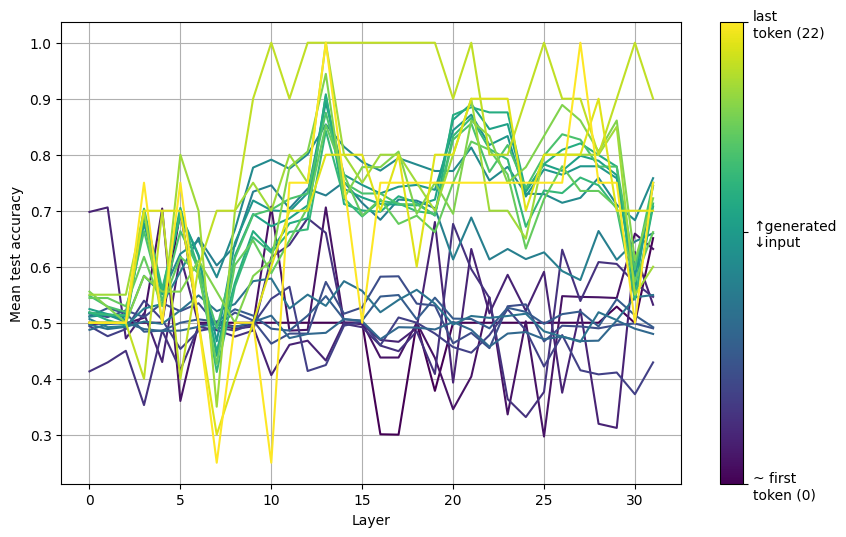

In [60]:
colors = matplotlib.cm.viridis(np.linspace(0, 1, mean_test_acc.shape[1]))  # Color map
x = range(0, num_modules)
fig, ax = plt.subplots(figsize=(10, 6))  # Define a figure and axes explicitlyx = range(0, num_modules)
for i in range(mean_test_acc.shape[1]):
    ax.plot(x, mean_test_acc[:, i], color=colors[i])

ax.grid()
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=mean_test_acc.shape[1]))
sm.set_array([])  # You need this line even though it's counterintuitive (sets up the ScalarMappable correctly)
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_ticks([0, mean_test_acc.shape[1]-10, mean_test_acc.shape[1]])  # Set ticks at the start and end
cbar.set_ticklabels([f'~ first\ntoken ({start_idx})', '\u2191generated\n\u2193input', f'last\ntoken ({end_idx})'])  # Label for each tick
# cbar.set_ticks([0, mean_test_acc.shape[1]])
# cbar.set_ticklabels([f'{start_idx}th\ntoken', 'last\nstatement\ntoken'])
# cbar.set_ticklabels([f'{start_idx}th\ntoken', f'{end_idx}th\ntoken'])

ax.set_ylabel('Mean test accuracy')
ax.set_xlabel('Layer')
plt.savefig(f"{plots_folder}/{probe_type}_mean_test_accs_train_{train_dataset['dataset_name']}_test_{test_dataset['dataset_name']}.png")
plt.show()

NameError: name 'probe_type' is not defined

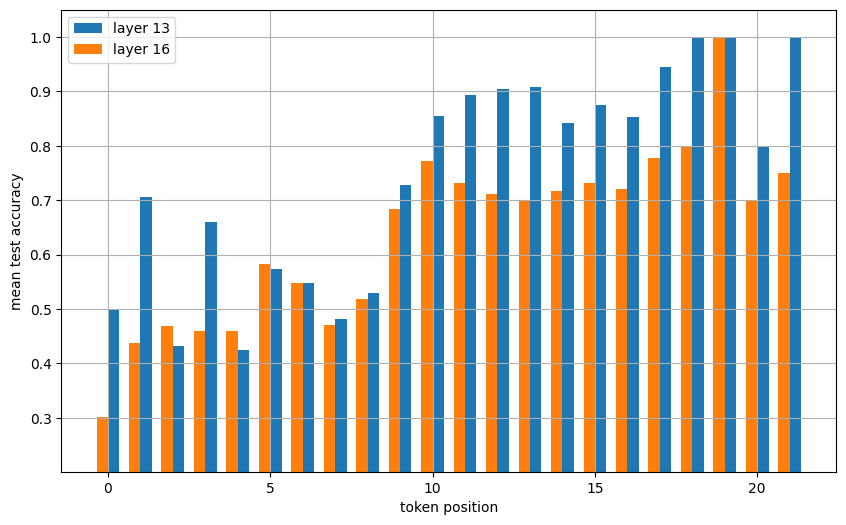

In [61]:
# make bar plot over all tokens
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
indices = range(len(non_nans))
indices = np.array(range(start_idx, end_idx))
bars2 = ax.bar(indices + width*0.5, mean_test_acc[13], width, label='layer 13')
bars2 = ax.bar(indices-width*0.5, mean_test_acc[16], width, label='layer 16')
# bars2 = ax.bar(indices - width*2/3, mean_test_acc[27], width, label='layer 27')
# Adding labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('token position')
ax.set_ylabel('mean test accuracy')
ax.set_ylim(min(mean_test_acc[13].min(),mean_test_acc[16].min())-0.1, max(mean_test_acc[13].max(),mean_test_acc[16].max())+0.05)
ax.set_title('')
ax.set_xticks(indices[::5])
ax.set_xticklabels([str(index) for index in indices[::5]])
ax.legend()
ax.grid()
plt.savefig(f"{plots_folder}/{probe_type}_mean_test_accs_bars_train_{train_dataset['dataset_name']}_test_{test_dataset['dataset_name']}.png")

plt.show()


100%|██████████| 32/32 [00:00<00:00, 531.13it/s]


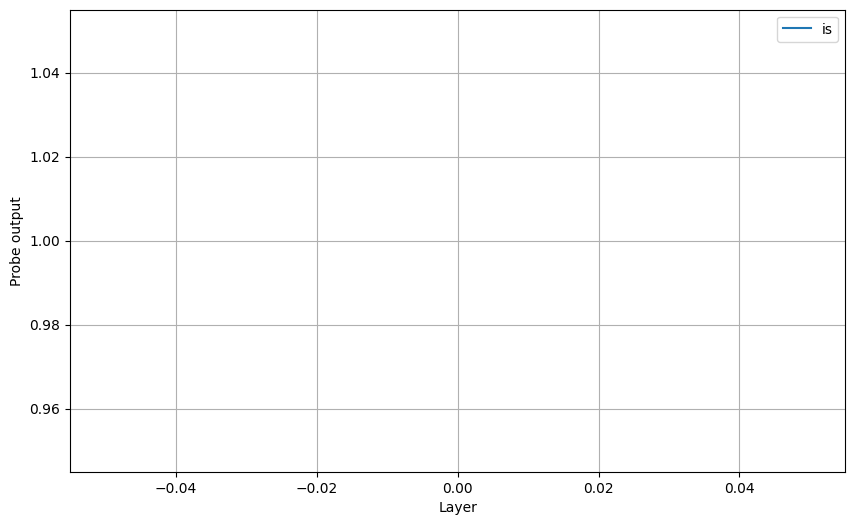

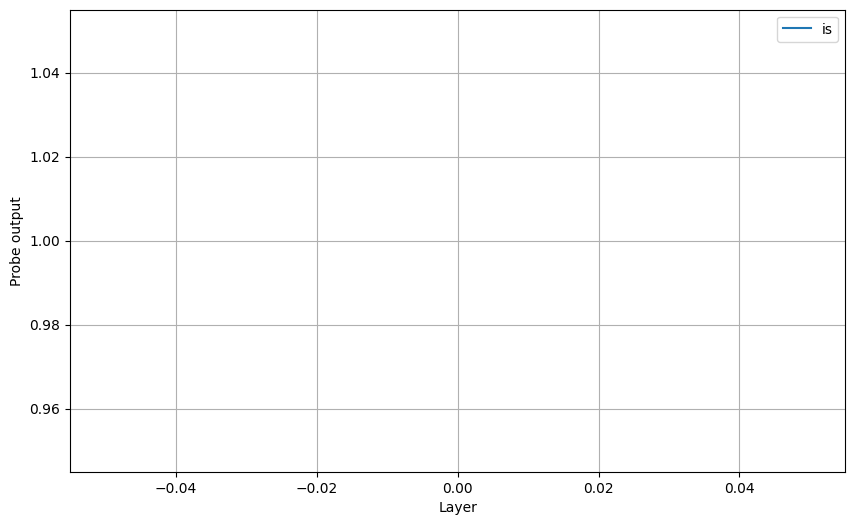

In [204]:
def plot_test_accs(test_accs, detokenized, train_dataset_name, test_dataset_name):
    # plot test accs for ood dataset
    plt.figure(figsize=(10, 6))

    for idx, label in enumerate(detokenized):
        plt.plot(test_accs[:, idx], label=label)
    plt.ylabel('Probe output')
    plt.xlabel('Layer')
    plt.grid()
    plt.legend()
    plt.savefig(f"{plots_folder}/{probe_type}_trained_{train_dataset_name}_tested_{test_dataset_name}.png")
    plt.show()



all_detokenized = []
all_test_accs = []
test_sentence = 'The capital of France is'
for format_sentence in [test_dataset['truth_format'].format(test_sentence), test_dataset['lie_format'].format(test_sentence)]:
    inputs = tokenizer(format_sentence, return_tensors="pt").to(model.device)
    decoded = []
    for idx, input_id in enumerate(inputs['input_ids'][0]):
        decoded.append(tokenizer.decode(input_id))
    all_detokenized.append(decoded)
    token_positions = range(inputs['input_ids'].shape[1])
    hidden_states = get_hidden_from_tokens(model, module_names, inputs, token_position=token_positions)

    # TODO: normalize

    hidden_states = hidden_states.to(device=device, dtype=torch.float32)
  
    test_accs_formats = torch.zeros((len(module_names), len(token_positions)))
    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        for token_pos in token_positions:
            test_accs_formats[idx][token_pos] = probes[module].forward(hidden_states[idx,:,token_pos, :]).detach().cpu()
    all_test_accs.append(test_accs_formats)

for idx, name in enumerate(['truth_format', 'lie_format']):
    plot_test_accs(all_test_accs[idx][11:], all_detokenized[idx][11:], train_dataset['dataset_name'], name)

